#**Employee Churn Analysis**

This notebook is to perform machine learning to predict employee churn in response to a request from the HR team. The analytics team will use predictive analytics to answer the following questions:

1. Which departments are most likely to experience high employee churn?
2. What are the main factors contributing to employee churn?


#1. Connect to Big Query

We firstly authenticates a Google Colab session, connects to Google BigQuery, and initializes a BigQuery client for the project 'employee-churn-project-451705', which is the project in the BigQuery server.

In [5]:
#Library
from google.cloud import bigquery
from google.colab import auth

#Authenticat
auth.authenticate_user()
# get project id
project_id = "employee-churn-project-451705"
# initialize client
client = bigquery.Client(project=project_id)

#2. Load the Dataset from cloud

This dataset is using for  training the model.

In [6]:
# load the dataset
dataset_ref = client.dataset("myemployeedata", project = project_id)
dataset = client.get_dataset(dataset_ref)
table_rf = dataset.table('tbl_hr_data')
table = client.get_table(table_rf)
table.schema

[SchemaField('satisfaction_level', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('last_evaluation', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('number_project', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('average_montly_hours', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('time_spend_company', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Work_accident', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Quit_the_Company', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('promotion_last_5years', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Departments', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('salary', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('employee_id', 'STRING', 'NULLABLE', None, None, (), None)]

We load the dataset of new imployee which we aim to predict the churning.

In [7]:
new_table_ref = dataset.table('tbl_newemployee')
new_table = client.get_table(new_table_ref)
new_table.schema

[SchemaField('satisfaction_level', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('last_evaluation', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('number_project', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('average_montly_hours', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('time_spend_company', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Work_accident', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Quit_the_Company', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('promotion_last_5years', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Departments', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('salary', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('employee_id', 'STRING', 'NULLABLE', None, None, (), None)]

#3. Convert the dataset to dataframe

In [8]:
df1 = client.list_rows(table).to_dataframe()
df1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Quit_the_Company,promotion_last_5years,Departments,salary,employee_id
0,0.38,0.53,2,157,3,0,1,0,sales,low,EMP00001
1,0.80,0.86,5,262,6,0,1,0,sales,medium,EMP00002
2,0.11,0.88,7,272,4,0,1,0,sales,medium,EMP00003
3,0.72,0.87,5,223,5,0,1,0,sales,low,EMP00004
4,0.37,0.52,2,159,3,0,1,0,sales,low,EMP00005


In [9]:
df2 = client.list_rows(new_table).to_dataframe()
df2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Quit_the_Company,promotion_last_5years,Departments,salary,employee_id
0,0.537849,0.122914,2,208,2,0,0,0,IT,high,NE15043
1,0.056211,0.322600,2,229,5,1,0,0,IT,low,NE15086
2,0.555186,0.555949,2,187,3,0,0,0,RandD,medium,NE15035
3,0.605273,0.713086,2,218,3,0,0,0,RandD,high,NE15069
4,0.043437,0.162372,2,175,3,0,0,0,RandD,high,NE15082


We split the dataset into training and testing sets while using stratify sample for ensuring class balance in the target variable.

In [32]:
# The data into train and test set.
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1.drop('Quit_the_Company', axis = 1),
                                                    df1['Quit_the_Company'],
                                                    test_size = 0.2,
                                                     stratify=df1['Quit_the_Company'],
                                                    random_state = 42)


#4. Build the Classification Model

In [7]:
# check if pycarat is installed
try:
  import pycaret
  print("pycaret is installed")
except ImportError:
  print("pycaret is not installed")
  !pip install pycaret


pycaret is not installed
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 83.8

We prepares the dataset for automated feature engineering, model selection, and hyperparameter tuning in PyCaret.

**Initialize Model Setup (`setup`)**

- **`data=df_train`** – Uses the training dataset.
- **`target='Quit_the_Company'`** – Specifies the target variable.
- **`session_id=123`** – Ensures reproducibility.
- **`ignore_features=['Employee_ID']`** – Excludes `Employee_ID` from modeling.
- **`categorical_features=['salary', 'Departments']`** – Identifies categorical variables for proper encoding.

In [33]:
# Import model
from pycaret.classification import *

# create training dataframe
df_train = pd.concat([X_train, y_train], axis = 1)

# setup model
clf1 = setup(data = df_train,
            target = 'Quit_the_Company',
            session_id = 123,
            ignore_features=['Employee_ID'],
            categorical_features=['salary', 'Departments'])

,Description,Value
0,Session id,123
1,Target,Quit_the_Company
2,Target type,Binary
3,Original data shape,"(12003, 11)"
4,Transformed data shape,"(12003, 22)"
5,Transformed train set shape,"(8402, 22)"
6,Transformed test set shape,"(3601, 22)"
7,Ignore features,1
8,Numeric features,7
9,Categorical features,2


In [34]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9868,0.9929,0.9576,0.9867,0.9718,0.9632,0.9635,1.0170
dummy,Dummy Classifier,0.7616,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1380


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

#5. Model Selection

Base on the model comparision, Light Gradient Boosting Machnine outperfromed other model. Thus, we select this model and evaluate the peformance on the unseen data.

In [58]:
# Select the best model
lgbm = create_model('lightgbm')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9869,0.9930,0.9552,0.9897,0.9722,0.9636,0.9639
1,0.9834,0.9887,0.9453,0.9845,0.9645,0.9536,0.9539
2,0.9893,0.9924,0.9600,0.9948,0.9771,0.9701,0.9704
3,0.9893,0.9971,0.9700,0.9848,0.9773,0.9703,0.9704
4,0.9905,0.9959,0.9750,0.9848,0.9799,0.9737,0.9737
5,0.9869,0.9918,0.9600,0.9846,0.9722,0.9636,0.9637
6,0.9869,0.9938,0.9600,0.9846,0.9722,0.9636,0.9637
7,0.9881,0.9927,0.9700,0.9798,0.9749,0.9671,0.9671
8,0.9857,0.9969,0.9500,0.9896,0.9694,0.9601,0.9604


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [59]:
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#6. Model Performance Evaluation

We use the remaining 20% for avaluating the model perfomance.

In [63]:
df_test = pd.concat([X_test, y_test], axis = 1)
df_test_pred = predict_model(lgbm, data = df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9853,0.9936,0.9538,0.9841,0.9688,0.9592,0.9594


The **LGBM model** demonstrates exceptional performance across all key evaluation metrics:

- **Accuracy:** 98.53% – The model accurately predicts employee churn for nearly 99% of the instances.
- **AUC (Area Under the Curve):** 0.9936 – The model performs very well in distinguishing between classes, with a near-perfect AUC score.
- **Recall:** 95.38% – The model identifies 95.38% of the actual churn cases, minimizing false negatives.
- **Precision:** 98.41% – The model correctly classifies 98.41% of predicted churn instances, reducing false positives.
- **F1-Score:** 96.88% – The model strikes a great balance between precision and recall, making it highly reliable.
- **Kappa:** 0.9592 – The model has excellent agreement with the true class labels, indicating a strong performance.
- **MCC (Matthews Correlation Coefficient):** 0.9594 – A high MCC score further validates the model’s overall ability to classify both positive and negative cases accurately.

Overall, the **LGBM model** is highly reliable, with strong predictive power in identifying employees likely to churn, making it an ideal choice for this problem.


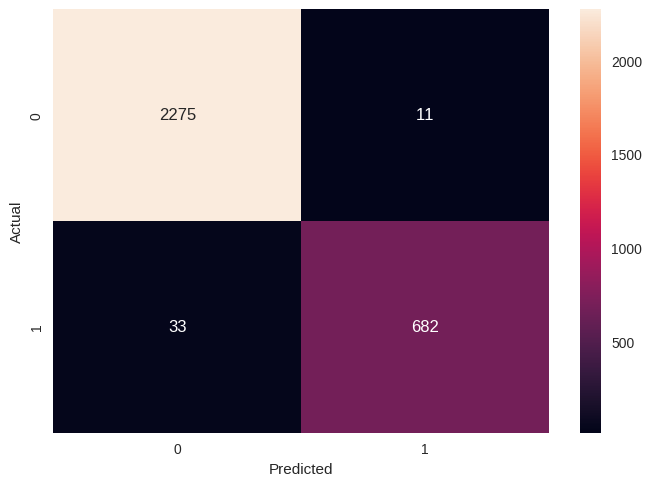

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y = df_test_pred['Quit_the_Company']
y_pred = df_test_pred['prediction_label']

# plot confusion metrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#7. Prediction

After we got a high performance model, we can use it to prodict the churn of the new employees dataset.

In [62]:
final_pred_df = predict_model(lgbm, data = df2)
final_pred_df.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8500,0,0.0000,0.0000,0.0000,0.0000,0.0000


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,Departments,salary,employee_id,Quit_the_Company,prediction_label,prediction_score
0,0.537849,0.122914,2,208,2,0,0,IT,high,NE15043,0,0,0.9998
1,0.056211,0.322600,2,229,5,1,0,IT,low,NE15086,0,1,0.9927
2,0.555186,0.555949,2,187,3,0,0,RandD,medium,NE15035,0,0,0.9985
3,0.605273,0.713086,2,218,3,0,0,RandD,high,NE15069,0,0,0.9972
4,0.043437,0.162372,2,175,3,0,0,RandD,high,NE15082,0,1,0.6947


#8. Important Features for the Prediction

This section we extract the feature important that give the predictive power to our model. Those high importance also mean it is the high factor contribute to the churning.

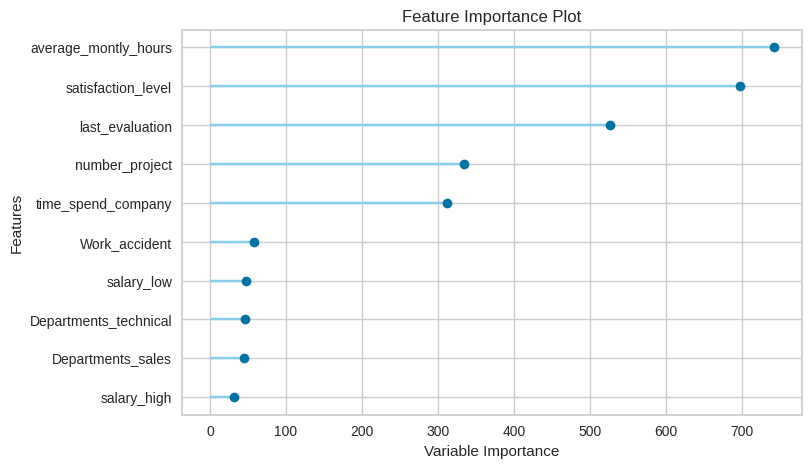

In [17]:
# Get the important features
plot_model(lgbm, plot = 'feature')

In [ ]:
# create a feature table
import pandas as pd

feature_impertant = pd.DataFrame(
    zip(lgbm.feature_names_in_,
    lgbm.feature_importances_),
    columns = ['feature', 'importance']
)

feature_impertant.head()

,feature,importance
0,satisfaction_level,698
1,last_evaluation,526
2,number_project,334
3,average_montly_hours,742
4,time_spend_company,312


#9. Upload Result to Big Query

In [ ]:
# Write the prediction to big quary
final_pred_df.to_gbq(destination_table = 'myemployeedata.tbl_pred_employee',
                     project_id = project_id,
                     if_exists = 'replace')

100%|██████████| 1/1 [00:00<00:00, 9664.29it/s]


In [ ]:
# Write the feature table to big quary
feature_impertant.to_gbq(destination_table = 'myemployeedata.tbl_feature',
                     project_id = project_id,
                      chunksize= None,
                     if_exists = 'replace')

100%|██████████| 1/1 [00:00<00:00, 3415.56it/s]
